In [ ]:
%tensorflow_version 1.x

In [ ]:
!pip3 uninstall -y keras
!pip3 install keras==2.1.0

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
!pip3 install -r requirements.txt
!python3 setup.py install

In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [5]:
class CustomConfig(Config):
    # Give the configuration a recognizable name
    NAME = "image_segmentation"
    
    NUM_CLASSES = 1 + 2

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# To use Google Drive Files
from google.colab import drive

drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [8]:
# copy over the dataset into the root directory of the Colab VM
!cp /mydrive/segmentedimages.zip ../

In [ ]:
# Unzip the dataset in the /Mask_RCNN/ folder
!unzip ../segmentedimages.zip 

In [7]:
class ImageDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        """dataset_dir: Root directory of the dataset."""
        self.add_class('dataset', 1, 'butterfly') 
        self.add_class('dataset', 2, 'squirrel')
        
        # find all images
        for i, filename in enumerate(os.listdir(dataset_dir)):
            if '.jpg' in filename:
                self.add_image('dataset', 
                               image_id=i, 
                               path=os.path.join(dataset_dir, filename), 
                               annotation=os.path.join(dataset_dir, filename.replace('.jpg', '.json')))
    
    def extract_masks(self, filename):
        json_file = os.path.join(filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        # masks: A bool array of shape [height, width, instance count] with one mask per instance.  
        masks = np.zeros([224, 320, len(img_anns['shapes'])], dtype='uint8')
        # classes: a list of class IDs of the instance masks.
        classes = []

        # Convert polygons to a bitmap mask of shape [height, width, instance_count]
        for i, anno in enumerate(img_anns['shapes']):
            mask = np.zeros([224, 320], dtype=np.uint8)
            cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), color=255)
            masks[:, :, i] = mask
            classes.append(self.class_names.index(anno['label']))
        return masks, classes
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load JSON
        masks, classes = self.extract_masks(path)
        return masks, np.asarray(classes, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [8]:
# Create training and validation set
# train set
dataset_train = ImageDataset()
dataset_train.load_dataset('segmentedimages/train')
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
 
# validation set
dataset_val = ImageDataset()
dataset_val.load_dataset('segmentedimages/test')
dataset_val.prepare()
print('Validation: %d' % len(dataset_val.image_ids))

Train: 592
Validation: 200


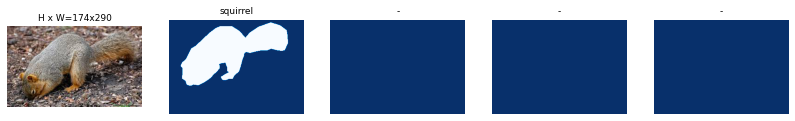

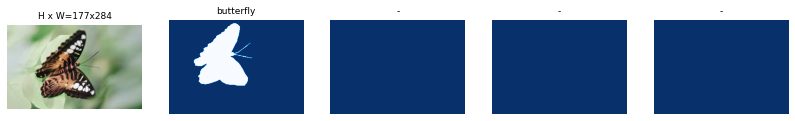

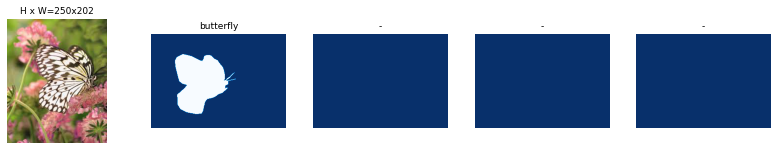

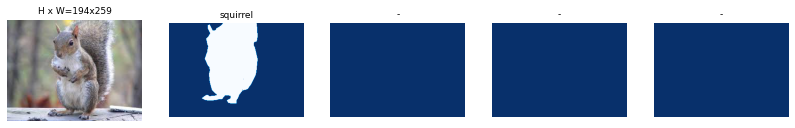

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [11]:
init_with = "coco"  # weights to start with: imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
  # Exclude the last layers because they require a matching number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

In [12]:
# Passing layers="heads" freezes all layers except the head layers. 
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')

# Passing layers="all" trains all layers.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=10, 
#             layers="all")


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/image_segmentation20201012T0248/mask_rcnn_image_segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.8182 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2986 - mrcnn_mask_loss: 0.2027

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



1000/1000 [==============================] - 641s 641ms/step - loss: 0.8181 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.2742 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.2028 - val_loss: 0.6665 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.2725 - val_mrcnn_class_loss: 0.0319 - val_mrcnn_bbox_loss: 0.1909 - val_mrcnn_mask_loss: 0.1678
Epoch 2/10
1000/1000 [==============================] - 560s 560ms/step - loss: 0.5691 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.2112 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.1703 - val_loss: 0.5928 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 0.2655 - val_mrcnn_class_loss: 0.0228 - val_mrcnn_bbox_loss: 0.1563 - val_mrcnn_mask_loss: 0.1446
Epoch 3/10
1000/1000 [==============================] - 565s 565ms/step - loss: 0.5069 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1924 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.1552 - val_loss: 0.6573 - val_rpn_cl

In [13]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get the path of saved weights
weights_path = model.find_last()

# Load trained weights
print("Loading weights from ", weights_path)
model.load_weights(weights_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/logs/image_segmentation20201012T0248/mask_rcnn_image_segmentation_0010.h5
Re-starting from epoch 10


In [14]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


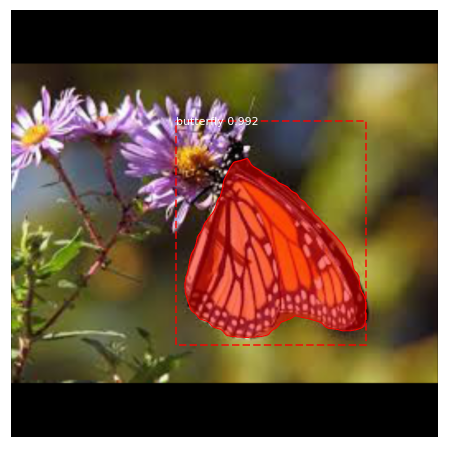

In [20]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(1))